In [364]:
import cirq
import Su22 as su
import qutip as qt
import scipy.signal as si
import scipy.linalg as la
from mezze.tfq import *
import pickle as pk
import random
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle
import numpy as np
def loadData(inp):
    # for reading also binary mode is important
    dbfile = open(inp, 'rb')     
    db = pickle.load(dbfile)
    dbfile.close()
    return db

In [296]:
# System parameters
N = 128
dt = 20/9*1e-10
T = N*dt
dw = 2*np.pi/T
Nw = 8192
ww = np.linspace(0,np.pi,Nw)
test = loadData('FGRAFS_controls/FGRAFS-controls_N-128_zero-endpoints-True-wH10.p')
test= test/np.max(np.abs(test))
power = np.sum(test**2)*dt
print(power)

1.811817773835958e-08


In [113]:
# Useful filter function calculator
def FF(control):
    Theta = np.cumsum(control)*dt
    ff = np.abs(np.fft.rfft( np.cos(Theta), 2*Nw-1)*dt)**2 + np.abs(np.fft.rfft( np.sin(Theta), 2*Nw-1)*dt)**2
    return ff/T**2

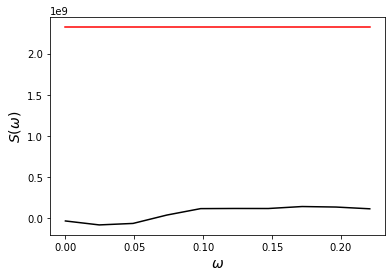

In [330]:
pk=10
plt.plot(np.arange(N)[:pk]*np.pi/N, test[:pk], color='k')
plt.plot(np.arange(N)[:pk]*np.pi/N, controls[:pk], color='r')
plt.ylabel('$S(\omega)$', fontsize=14)
plt.xlabel('$\omega$', fontsize=14)
plt.show()

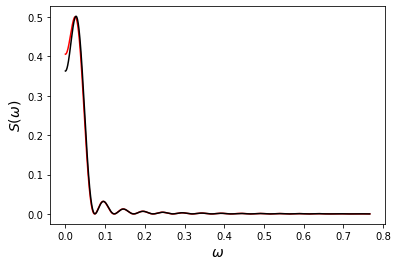

In [367]:
pk=2000
plt.plot(ww[:pk], FF(controls)[:pk], color='r')
plt.plot(ww[:pk], FF(test)[:pk], color='k')
plt.ylabel('$S(\omega)$', fontsize=14)
plt.xlabel('$\omega$', fontsize=14)
plt.show()

### Controls

In [366]:
# Center frequency of FF
wH = dw*1
controls = wH**np.ones(N)

# Amplitude shifting to get a π pulse
delta_w = (np.pi - wH*T + (wH*T - np.sum(controls)*dt % (2*np.pi)) )/T
controls *= (delta_w+wH)/wH
print(controls[0])
# Compute control power
power = np.sum(controls**2)*dt
print(power)

110446616.7277662
346978279.7257979


[0.0, 0.23, 0.55, 0.96, 0.96, 0.56, 0.23, 0.0, 0.19, 0.51, 0.95, 0.97, 0.7, 0.29, 0.02, 0.1, 0.59, 0.88, 0.95, 0.64, 0.26, 0.02, 0.16, 0.44, 0.91]
[ 0.115   0.1375  0.1825  0.1025 -0.1    -0.1825 -0.14   -0.01    0.1275
  0.19    0.115  -0.0625 -0.17   -0.17   -0.0475  0.1425  0.195   0.09
 -0.06   -0.1725 -0.155  -0.025   0.105   0.1875  0.235 ]
4
0.1474006138338423


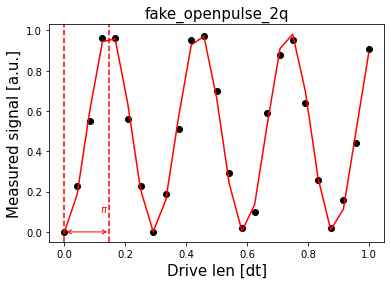

In [365]:
from qiskit.providers.fake_provider import FakeOpenPulse2Q
backend = FakeOpenPulse2Q()
pulse = su.Custom_Fgp('low_freq',controls,backend)

7.0


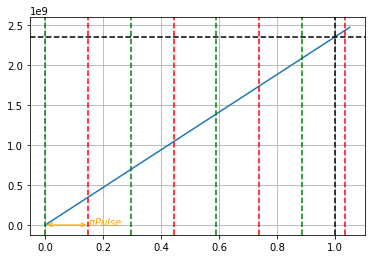

In [427]:
x = np.linspace(0,1.05)
print(np.rint(1/pulse.pi_p))
plt.plot(x,(power/pulse.pi_p)*x)
[plt.axvline((2*i+1)*pulse.pi_p, color='red', linestyle='--') for i in range(1+int(np.rint(1/(2*pulse.pi_p))))]
[plt.axvline((2*i)*pulse.pi_p, color='green', linestyle='--') for i in range(1+int(np.rint(1/(2*pulse.pi_p))))]
plt.axhline((power/pulse.pi_p), color='black', linestyle='--')
plt.axvline((1), color='black', linestyle='--')
plt.annotate("", xy=(0, 0), xytext=(pulse.pi_p,0), arrowprops=dict(arrowstyle="<->", color='orange'))
plt.annotate("$\pi Pulse$", xy=(pulse.pi_p-0.001, 0.5), color='orange')

plt.grid()
plt.show()

In [298]:
# Amplitude shifting to get a π pulse
for _ in range(1000000):
    delta_w = (np.pi - wH*T + (wH*T - np.sum(test)*dt % (2*np.pi)) )/T
    test *= (delta_w+wH)/wH

# Compute control power
power = np.sum(test**2)*dt
print(power)

377749330.47563845


In [361]:
zero_state = [1,0]
one_state = [0,1]

U_n = qt.identity(2).full()
for n,Omega_n in enumerate(test):
    H_n = qt.sigmax().full()*Omega_n/2
    U_n = la.expm(-1j*dt*H_n) @ U_n
    final_state = U_n@zero_state
    gate_fidelity = np.abs(final_state.transpose().conj() @ one_state)**2
    #print(gate_fidelity)
print(U_n)
final_state = U_n@zero_state

gate_fidelity = np.abs(final_state.transpose().conj() @ one_state)**2
print("Ideal gate fidelity: %.8f"%gate_fidelity)

[[-6.94702542e-16+0.j  0.00000000e+00-1.j]
 [ 0.00000000e+00-1.j -5.81511835e-16+0.j]]
Ideal gate fidelity: 1.00000000


## Bandpass noise

In [170]:
# Compute arma coefficients for narrow band noise with center wc 
def arma_coefficients(wc):
    b = si.firwin(128, .001)
    b *= np.cos(wc*np.arange(len(b)))
    b = b/np.linalg.norm(b)*.1
    return b

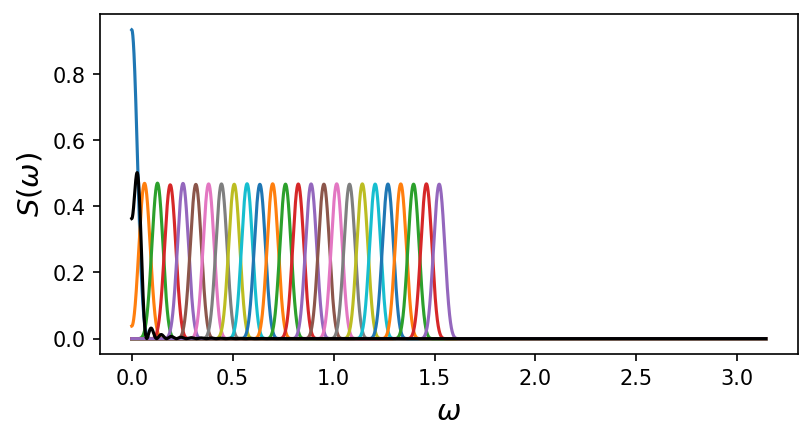

In [306]:
# center frequencies of injected PSD
center_freqs = np.linspace(0, .5*np.pi, 100)

plt.figure(figsize=(6,3), dpi=150)

for wc in center_freqs[::4]:
    b = arma_coefficients(wc)
    S = SimpleDephasingSchWARMAFier(b, [1,])
    plt.plot(*S.psd(worN=Nw))
    
plt.plot(ww, FF(test), color='k')
plt.ylabel('$S(\omega)$', fontsize=14)
plt.xlabel('$\omega$', fontsize=14)
plt.show()

### Noise trajectories

In [98]:
# Generate dummy circuit to get noise trajectories from schwarma
dummy_circ = cirq.Circuit([cirq.I(cirq.GridQubit(1,1))]*N)

In [99]:
# Generate sample trajectories
b = arma_coefficients(center_freqs[0])
S = SimpleDephasingSchWARMAFier(b, [1,])
noise_trajectories = S.gen_noise_instances(dummy_circ,100) # 1000 different trajectories

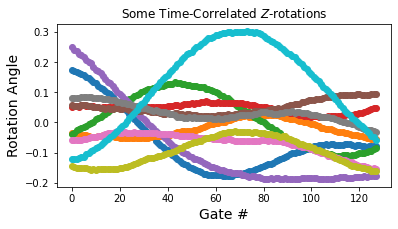

In [100]:
plt.figure(figsize=(6,3))
plt.plot(noise_trajectories[:10].T,'-o')
plt.ylabel('Rotation Angle', size=14)
plt.xlabel(r'Gate #', size=14)
plt.title(r'Some Time-Correlated $Z$-rotations')
plt.show()

## Simulations scanning over different center frequencies

In [226]:
fidelity_wc = {}

# Scan over frequencies by varying noise center frequency
num_trajs = 10 # recommend: 10 for quick test, 100 for better resolution
for wc in tqdm(center_freqs):
    b = arma_coefficients(wc)
    S = SimpleDephasingSchWARMAFier(b, [1,])
    noise_trajectories = S.gen_noise_instances(dummy_circ, num_trajs)
    
    noisy_fidelities = []
    # Average over noise trajectories
    for beta in noise_trajectories:
        beta *= np.sqrt(0.01/np.sum(beta**2)) # Rescale for reasonable power

        U_n = qt.identity(2).full()
        for n,Omega_n in enumerate(test):
            H_n = qt.sigmax().full()*Omega_n/2
            U_n = la.expm(-1j*qt.sigmaz().full()*beta[n]) @ la.expm(-1j*dt*H_n) @ U_n
        final_state = U_n@zero_state
        
        noisy_fidelities += [np.abs(final_state.transpose().conj() @ one_state)**2]
        
    fidelity_wc[wc] = np.mean(noisy_fidelities)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


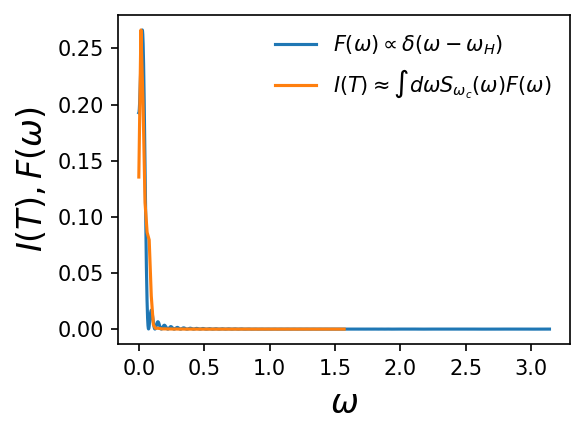

In [227]:
plt.figure(dpi=150, figsize=(4,3))

infidelity = 1-np.array(list(fidelity_wc.values()))
filter_function = FF(test)

plt.plot(ww, filter_function*np.max(infidelity)/np.max(filter_function), 
         label=r'$F(\omega)\propto \delta(\omega-\omega_H)$')
plt.plot(center_freqs, infidelity, 
         label=r'$I(T)\approx \int d\omega S_{\omega_c}(\omega) F(\omega)$')
plt.ylabel('$I(T), F(\omega)$',size=16)
plt.xlabel('$\omega$',size=16)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()